In [1]:
!pip install split-folders

### **Importing of Necessary Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [4]:
base_ds = '/kaggle/input/rosenet/Original Dataset'
base_ds = pathlib.Path(base_ds)

In [5]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.6,.2,.2), group_prefix=None)

Copying files: 917 files [00:09, 98.24 files/s]


In [6]:
Blackspot= [fn for fn in os.listdir(f'{base_ds}/Black Spot') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
DownyMildew= [fn for fn in os.listdir(f'{base_ds}/Downy Mildew') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
FreshLeaf= [fn for fn in os.listdir(f'{base_ds}/Fresh Leaf') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Die_Back= [fn for fn in os.listdir(f'{base_ds}/Die Back') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Gall_Midge= [fn for fn in os.listdir(f'{base_ds}/Gall Midge') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Healthy= [fn for fn in os.listdir(f'{base_ds}/Healthy') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Powdery_Mildew= [fn for fn in os.listdir(f'{base_ds}/Powdery Mildew') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Sooty_Mould= [fn for fn in os.listdir(f'{base_ds}/Sooty Mould') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]


coffee= [Blackspot, DownyMildew, FreshLeaf]
coffee_classes = []
for i in os.listdir('imgs/train'):
    coffee_classes+=[i]
coffee_classes.sort()



### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 917
Total number of classes: 3
Total Black Spot images: 313
Total Downy Mildew images: 200
Total Fresh Leaf images: 404


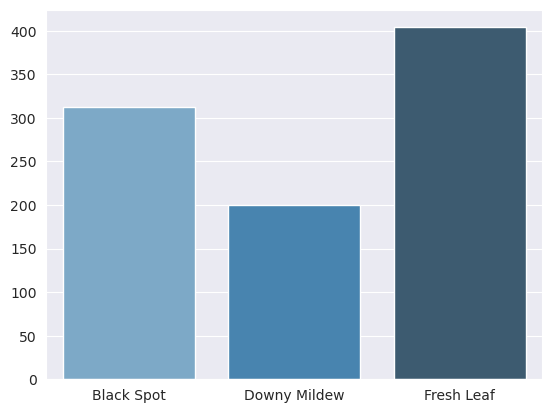

In [7]:
image_count1= len(list(base_ds.glob('*/*.jpg')))
image_count2 = len(list(base_ds.glob('*/*.jpeg')))
image_count=image_count1+image_count2
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')
count = 0
coffee_count = []
for x in coffee_classes:
  print(f'Total {x} images: {len(coffee[count])}')
  coffee_count.append(len(coffee[count]))
  count+=1

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (1396, 1109, 3)


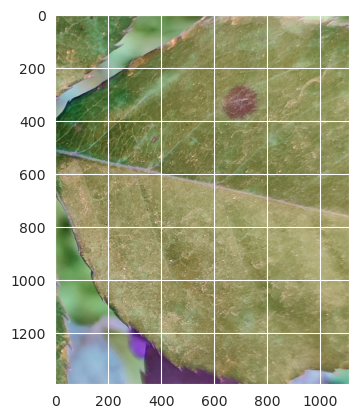

In [8]:
sample_img = cv2.imread('/kaggle/input/rosenet/Original Dataset/Black Spot/Black Spot (1).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [9]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in coffee_classes:
    i+=1
    plt.subplot(1,8, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

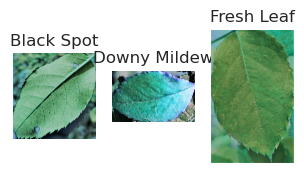

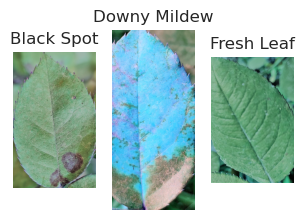

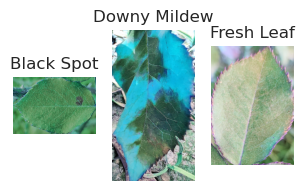

In [10]:
for i in range(3):
  load_random_img(base_ds,coffee_classes)

In [11]:
batch_size =16
img_height, img_width =128,128
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =16,
            img_height=128,
            img_width =128,
            )

### **Data Pre-processing**

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

In [13]:
train_ds = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical',
    shuffle=True
    )

val_ds = train_datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 549 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
Found 186 images belonging to 3 classes.


In [14]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

CONFIG['model_name'] = 'DenseNet121'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='train')

wandb.config.type = 'baseline'

In [15]:
CONFIG['model_name'] = 'DenseNet121'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='train')

wandb.config.type = 'baseline'

wandb: Currently logged in as: sanjeevsharma22. Use `wandb login --relogin` to force relogin


Training configuration:  {'batch_size': 16, 'img_height': 128, 'img_width': 128, 'model_name': 'DenseNet121'}


wandb: wandb version 0.15.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230812_183152-xrqmjroq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tough-plant-40
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/xrqmjroq


## **Transfer Learning**

In [16]:
model=tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model= tf.keras.Model(inputs, x)

29084464/29084464 [==============================] - 0s 0us/step


In [17]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 8,090,179
Trainable params: 8,006,531
Non-trainable params: 83,648
______________________________________________

## **Fine Tuning**

In [18]:
history3 =model.fit(train_ds, epochs =30, validation_data = val_ds,callbacks=[WandbCallback()])
run.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.6794

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.5s


35/35 [==============================] - 169s 3s/step - loss: 0.7449 - accuracy: 0.6794 - val_loss: 0.4643 - val_accuracy: 0.8297
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8525

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.5s


35/35 [==============================] - 83s 2s/step - loss: 0.3624 - accuracy: 0.8525 - val_loss: 0.2508 - val_accuracy: 0.8956
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9089

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.5s


35/35 [==============================] - 83s 2s/step - loss: 0.2215 - accuracy: 0.9089 - val_loss: 0.2055 - val_accuracy: 0.9231
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9472

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.5s


35/35 [==============================] - 84s 2s/step - loss: 0.1576 - accuracy: 0.9472 - val_loss: 0.1364 - val_accuracy: 0.9341
Epoch 5/30
35/35 [==============================] - 16s 444ms/step - loss: 0.1499 - accuracy: 0.9454 - val_loss: 0.1424 - val_accuracy: 0.9396
Epoch 6/30
35/35 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9362

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.5s


35/35 [==============================] - 83s 2s/step - loss: 0.1521 - accuracy: 0.9362 - val_loss: 0.0919 - val_accuracy: 0.9505
Epoch 7/30
35/35 [==============================] - 15s 436ms/step - loss: 0.0808 - accuracy: 0.9690 - val_loss: 0.1006 - val_accuracy: 0.9615
Epoch 8/30
35/35 [==============================] - 14s 406ms/step - loss: 0.0709 - accuracy: 0.9709 - val_loss: 0.1370 - val_accuracy: 0.9451
Epoch 9/30
35/35 [==============================] - 15s 431ms/step - loss: 0.0882 - accuracy: 0.9709 - val_loss: 0.1831 - val_accuracy: 0.9505
Epoch 10/30
35/35 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9709

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.4s


35/35 [==============================] - 83s 2s/step - loss: 0.0856 - accuracy: 0.9709 - val_loss: 0.0651 - val_accuracy: 0.9890
Epoch 11/30
35/35 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9872

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.5s


35/35 [==============================] - 85s 2s/step - loss: 0.0453 - accuracy: 0.9872 - val_loss: 0.0591 - val_accuracy: 0.9835
Epoch 12/30
35/35 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9854

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.5s


35/35 [==============================] - 84s 2s/step - loss: 0.0349 - accuracy: 0.9854 - val_loss: 0.0540 - val_accuracy: 0.9890
Epoch 13/30
35/35 [==============================] - 15s 422ms/step - loss: 0.0282 - accuracy: 0.9945 - val_loss: 0.0778 - val_accuracy: 0.9780
Epoch 14/30
35/35 [==============================] - 15s 419ms/step - loss: 0.0540 - accuracy: 0.9854 - val_loss: 0.1160 - val_accuracy: 0.9615
Epoch 15/30
35/35 [==============================] - 14s 405ms/step - loss: 0.0662 - accuracy: 0.9745 - val_loss: 0.0816 - val_accuracy: 0.9725
Epoch 16/30
35/35 [==============================] - 15s 427ms/step - loss: 0.0400 - accuracy: 0.9818 - val_loss: 0.1240 - val_accuracy: 0.9670
Epoch 17/30
35/35 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9945

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230812_183152-xrqmjroq/files/model-best)... Done. 0.5s


35/35 [==============================] - 83s 2s/step - loss: 0.0210 - accuracy: 0.9945 - val_loss: 0.0456 - val_accuracy: 0.9835
Epoch 18/30
35/35 [==============================] - 15s 445ms/step - loss: 0.0456 - accuracy: 0.9891 - val_loss: 0.0518 - val_accuracy: 0.9780
Epoch 19/30
35/35 [==============================] - 14s 410ms/step - loss: 0.0465 - accuracy: 0.9872 - val_loss: 0.0614 - val_accuracy: 0.9890
Epoch 20/30
35/35 [==============================] - 14s 405ms/step - loss: 0.0118 - accuracy: 0.9982 - val_loss: 0.0800 - val_accuracy: 0.9780
Epoch 21/30
35/35 [==============================] - 16s 464ms/step - loss: 0.0177 - accuracy: 0.9964 - val_loss: 0.1048 - val_accuracy: 0.9725
Epoch 22/30
35/35 [==============================] - 14s 408ms/step - loss: 0.0306 - accuracy: 0.9927 - val_loss: 0.0830 - val_accuracy: 0.9835
Epoch 23/30
35/35 [==============================] - 14s 407ms/step - loss: 0.0409 - accuracy: 0.9854 - val_loss: 0.0866 - val_accuracy: 0.9780
Epoch 2

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:     accuracy ▁▅▆▇▇▇▇▇▇▇████▇███████████████
wandb:        epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
wandb:         loss █▄▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_accuracy ▁▄▅▆▆▆▇▆▆████▇▇▇████▇███▇██▇▇█
wandb:     val_loss █▄▄▃▃▂▂▃▃▁▁▁▂▂▂▂▁▁▁▂▂▂▂▁▁▂▁▁▂▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.98361
wandb:    best_epoch 16
wandb: best_val_loss 0.04563
wandb:         epoch 29
wandb:          loss 0.04674
wandb:  val_accuracy 0.98901
wandb:      val_loss 0.0643
wandb: 
wandb: 🚀 View run tough-plant-40 at: https://wandb.ai/sanjeevsharma22/Rose/runs/xrqmjroq
wandb: Synced 6 W&B file(s), 1 media file(s), 45 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20230812_183152-xrqmjroq/logs


## **Final Evaluation**

In [19]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose', 
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

wandb: wandb version 0.15.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230812_185223-0202r98m
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run frosty-glitter-41
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/0202r98m


12/12 [==============================] - 6s 460ms/step - loss: 0.0250 - accuracy: 0.9892


wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run frosty-glitter-41 at: https://wandb.ai/sanjeevsharma22/Rose/runs/0202r98m
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230812_185223-0202r98m/logs


In [20]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.02499786578118801,"
" Accuracy: 98.92473220825195


In [21]:
Y_pred =model.predict(test_ds)

12/12 [==============================] - 5s 233ms/step


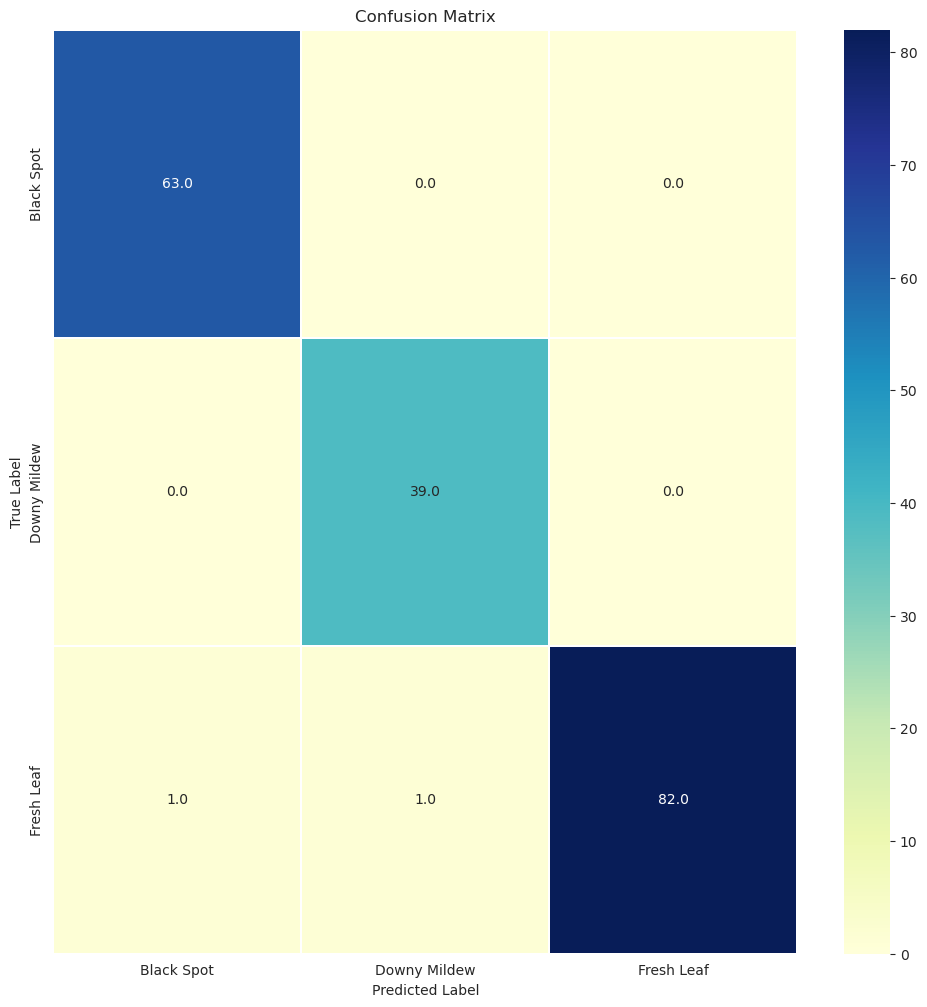

In [22]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [23]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
Black Spot,1.000000,0.984375,0.992126,64.000000
Downy Mildew,1.000000,0.975000,0.987342,40.000000
Fresh Leaf,0.976190,1.000000,0.987952,82.000000
accuracy,0.989247,0.989247,0.989247,0.989247
macro avg,0.992063,0.986458,0.989140,186.000000
weighted avg,0.989503,0.989247,0.989257,186.000000


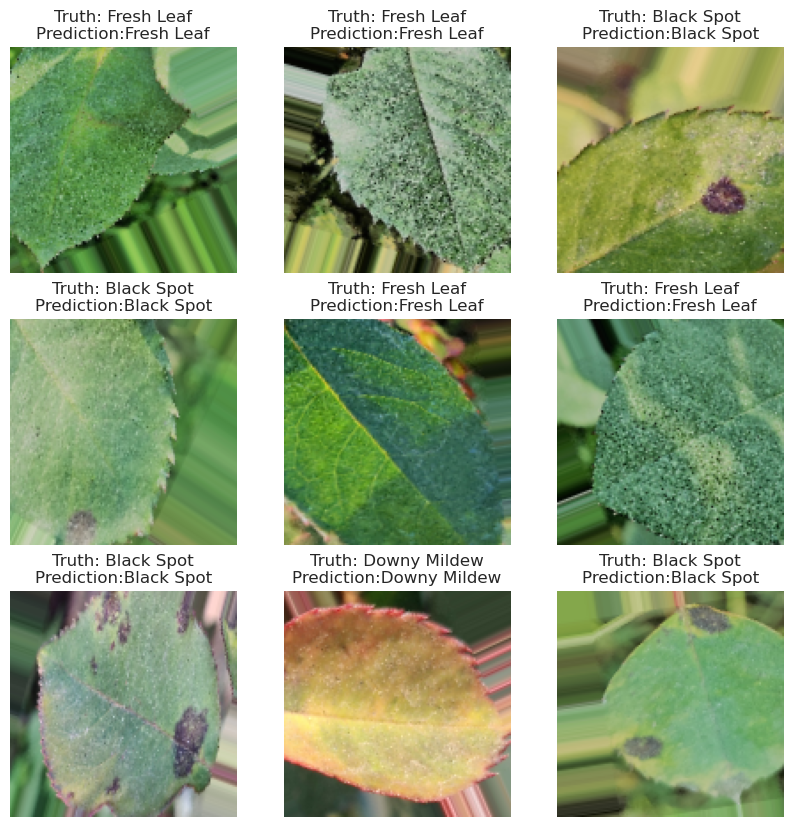

In [24]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [25]:
model.save('DenseNet121-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose', 
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='DenseNet121', type='model')
artifact.add_file('DenseNet121-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()

wandb: wandb version 0.15.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230812_185334-amo176i6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run iconic-deluge-42
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/amo176i6
wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run iconic-deluge-42 at: https://wandb.ai/sanjeevsharma22/Rose/runs/amo176i6
wandb: Synced 5 W&B file(s), 0 media file(s), 1 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230812_185334-amo176i6/logs


<h2>Support by giving an upvote!!</h2>